# Import Libraries

In [39]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import joblib

# Data Load and Preprocessing

## Load Dataset

In [40]:
df = pd.read_csv("Loan_Prediction.csv")

## Displaying Data info

In [41]:
print("First 5 rows of the dataset:")
print(df.head())

# Display shape and column info
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Basic statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural      

## Data Cleaning

In [42]:
# Drop Loan_ID as it is just an identifier
df.drop(columns=['Loan_ID'], inplace=True)

# Map Loan_Status from 'Y'/'N' to 1/0
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Handle missing values
# Categorical columns: use mode (most frequent)
cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Numerical columns: use mean
num_cols = ['LoanAmount', 'Loan_Amount_Term']
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Confirm no missing values remain
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


# EDA

In [43]:
# Set style
sns.set(style="whitegrid")

## Check target variable distribution

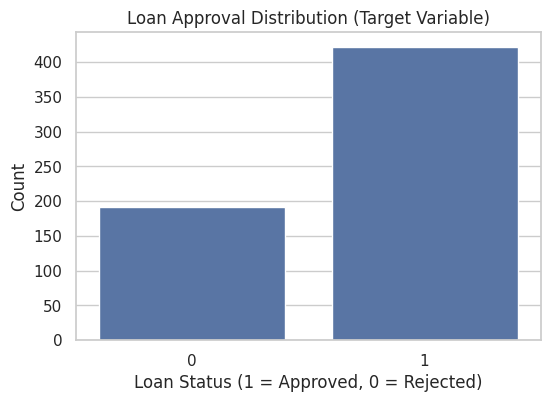

In [44]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Approval Distribution (Target Variable)")
plt.xlabel("Loan Status (1 = Approved, 0 = Rejected)")
plt.ylabel("Count")
plt.show()

## Categorical Features vs Target

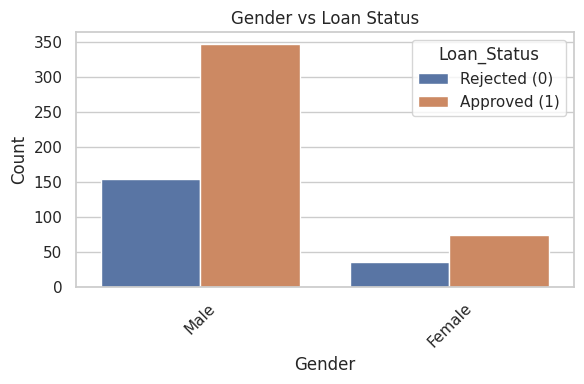

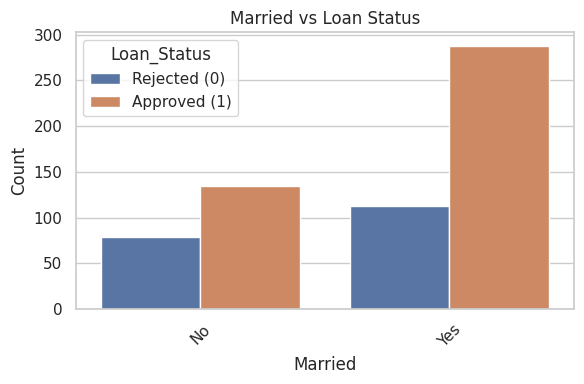

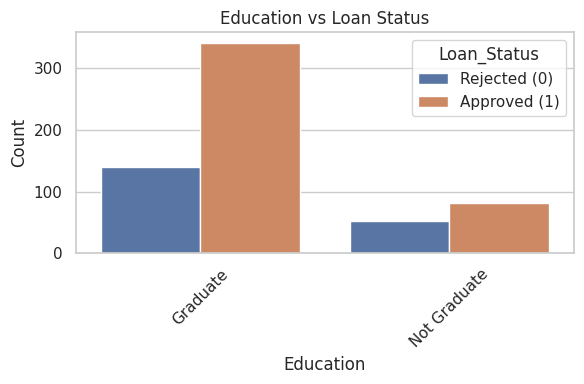

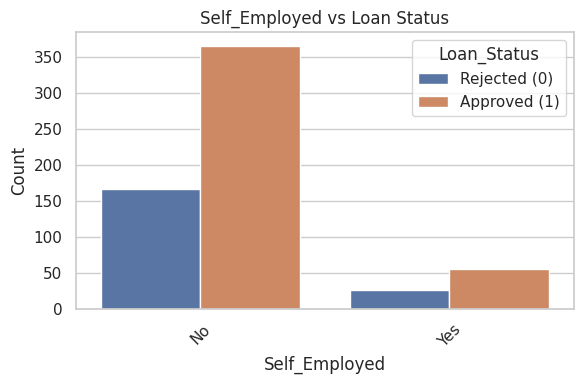

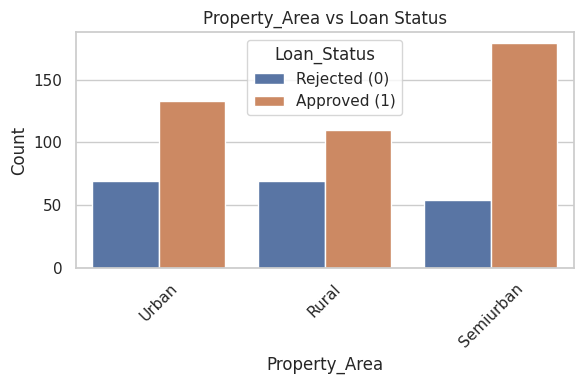

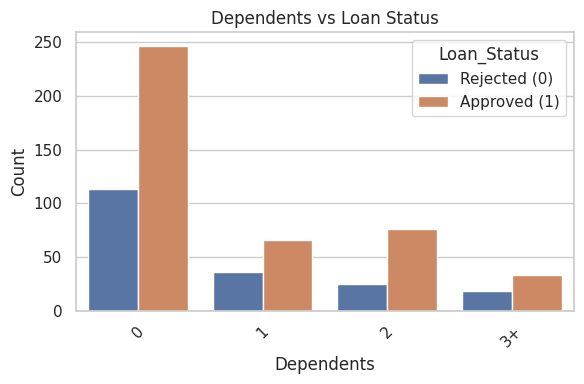

In [45]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='Loan_Status', data=df)
    plt.title(f"{col} vs Loan Status")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title='Loan_Status', labels=['Rejected (0)', 'Approved (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Numerical Feature Distributions

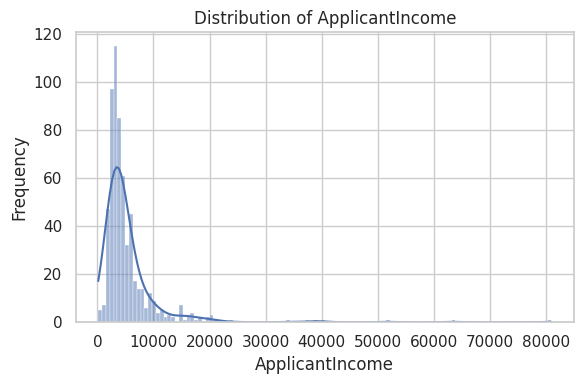

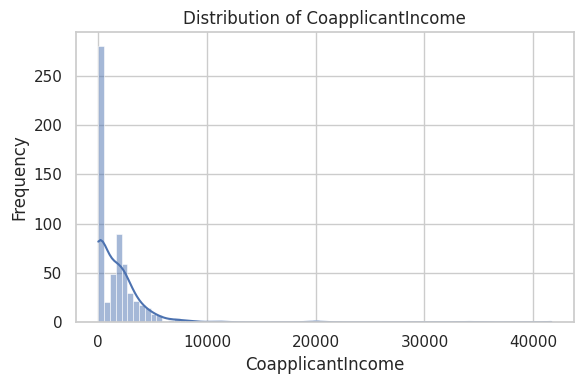

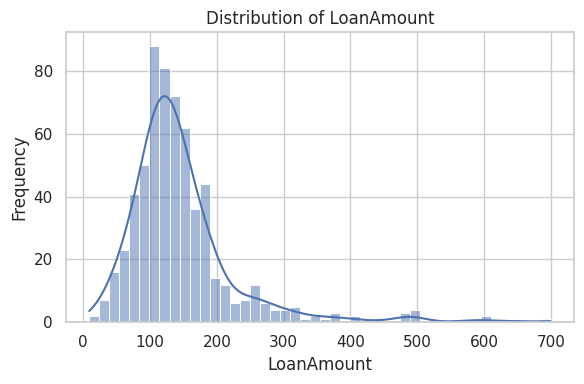

In [46]:
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## Histogram of key numeric features

<Figure size 1200x500 with 0 Axes>

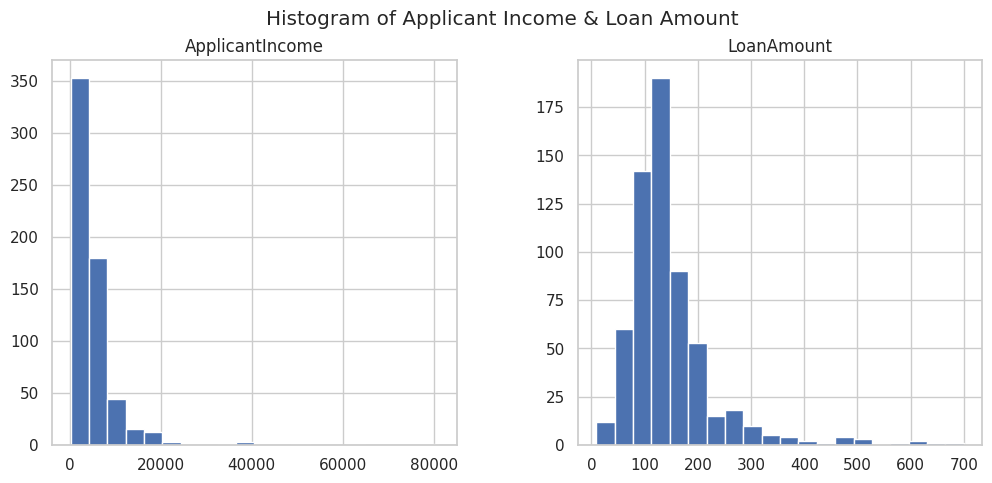

In [47]:
plt.figure(figsize=(12,5))
df[['ApplicantIncome', 'LoanAmount']].hist(bins=20, figsize=(12,5))
plt.suptitle("Histogram of Applicant Income & Loan Amount")
plt.show()

## Stacked Bar Chart: Loan_Status vs Property_Area

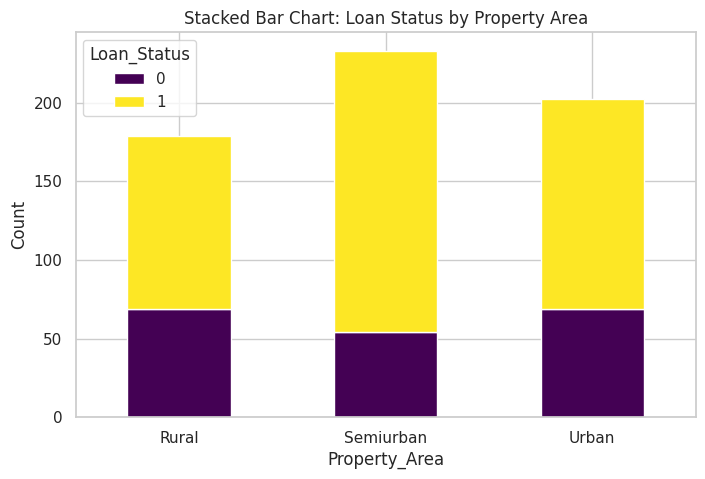

In [48]:
stacked_data = pd.crosstab(df['Property_Area'], df['Loan_Status'])
stacked_data.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
plt.title("Stacked Bar Chart: Loan Status by Property Area")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Stacked Bar Chart: Loan_Status vs Dependents

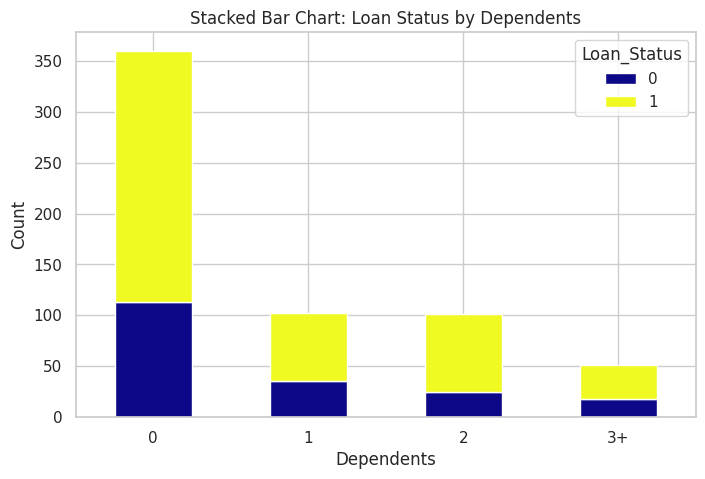

In [49]:
stacked_data_dep = pd.crosstab(df['Dependents'], df['Loan_Status'])
stacked_data_dep.plot(kind='bar', stacked=True, figsize=(8,5), colormap='plasma')
plt.title("Stacked Bar Chart: Loan Status by Dependents")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Correlation Heatmap

In [50]:
df_corr = df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term','Loan_Status']]

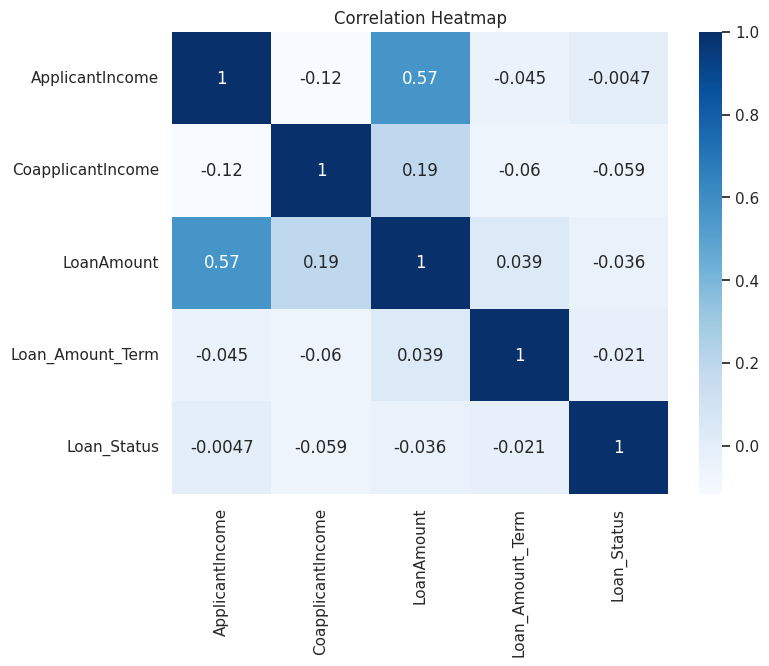

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

# Feature Engineering

In [52]:
# Make a copy to preserve original
df_encoded = df.copy()

## Label Encode binary categorical variables

In [53]:
label_cols = ['Gender', 'Married', 'Education', 'Self_Employed']
le = LabelEncoder()
for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

## Define features (X) and target (y)

In [54]:
# Convert 'Dependents' to numeric (replace '3+' with 3)
df_encoded['Dependents'] = df_encoded['Dependents'].replace('3+', 3).astype(int)

# One-hot encode 'Property_Area' (more than 2 categories)
df_encoded = pd.get_dummies(df_encoded, columns=['Property_Area'], drop_first=True)

X = df_encoded.drop('Loan_Status', axis=1)
y = df_encoded['Loan_Status']

## Scale numerical features

In [55]:
scaler = StandardScaler()
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
X[num_cols] = scaler.fit_transform(X[num_cols])

# Show final feature set
print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)
print("\nFinal Feature Columns:")
print(X.columns)

Feature matrix shape: (614, 12)
Target variable shape: (614,)

Final Feature Columns:
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')


# Model Ealuation

## Logistic Regression

### Split data into training and testing sets (80% train, 20% test)

In [56]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Initialize and predictions

In [57]:
# Initialize and train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[22 16]
 [ 1 84]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123


Accuracy Score: 0.8617886178861789


## Decision Tree

### train the Decision Tree model

In [58]:
# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Make predictions

In [59]:
dt_pred = dt_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_pred))

print("\nClassification Report:")
print(classification_report(y_test, dt_pred))

print("\nAccuracy Score:", accuracy_score(y_test, dt_pred))

Confusion Matrix:
[[21 17]
 [18 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.55        38
           1       0.80      0.79      0.79        85

    accuracy                           0.72       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.72      0.72      0.72       123


Accuracy Score: 0.7154471544715447


## Ensemble Model

### train Random Forest model

In [60]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Make predictions

In [61]:
rf_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

print("\nAccuracy Score:", accuracy_score(y_test, rf_pred))

Confusion Matrix:
[[25 13]
 [ 6 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.72        38
           1       0.86      0.93      0.89        85

    accuracy                           0.85       123
   macro avg       0.83      0.79      0.81       123
weighted avg       0.84      0.85      0.84       123


Accuracy Score: 0.8455284552845529


## KNN

### train KNN model

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

### Predictions

In [63]:
knn_pred = knn_model.predict(X_test)

# Evaluation
print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_test, knn_pred))

print("\nKNN Classification Report:")
print(classification_report(y_test, knn_pred))

print("\nKNN Accuracy Score:", accuracy_score(y_test, knn_pred))


KNN Confusion Matrix:
[[19 19]
 [ 3 82]]

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        38
           1       0.81      0.96      0.88        85

    accuracy                           0.82       123
   macro avg       0.84      0.73      0.76       123
weighted avg       0.83      0.82      0.80       123


KNN Accuracy Score: 0.8211382113821138


## XGBoost

### Ensure all features are numeric for XGBoost


In [64]:
X_train_xgb = X_train.apply(pd.to_numeric)
X_test_xgb = X_test.apply(pd.to_numeric)

### train XGBoost model

In [65]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_xgb, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:33:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Predictions

In [66]:
xgb_pred = xgb_model.predict(X_test_xgb)

# Evaluation
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

print("\nXGBoost Accuracy Score:", accuracy_score(y_test, xgb_pred))


XGBoost Confusion Matrix:
[[25 13]
 [10 75]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68        38
           1       0.85      0.88      0.87        85

    accuracy                           0.81       123
   macro avg       0.78      0.77      0.78       123
weighted avg       0.81      0.81      0.81       123


XGBoost Accuracy Score: 0.8130081300813008


# Model Comparison

## ROC-AUC curve

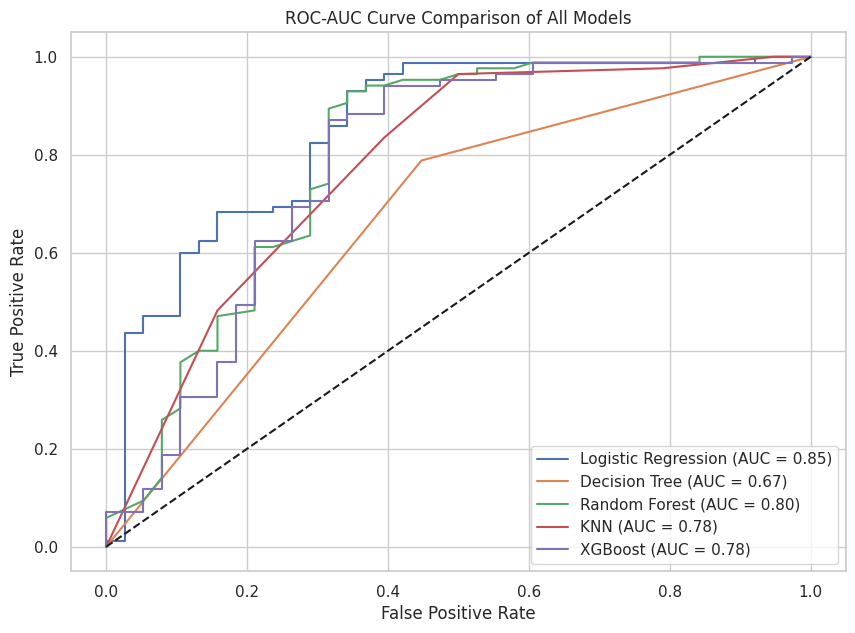

In [67]:
plt.figure(figsize=(10, 7))

# Dictionary of all models
all_models = {
    "Logistic Regression": logreg,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "KNN": knn_model,
    "XGBoost": xgb_model
}

for name, model in all_models.items():
    # Use numeric X_test for XGBoost
    if name == "XGBoost":
        y_prob = model.predict_proba(X_test_xgb)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison of All Models")
plt.legend(loc="lower right")
plt.show()

## Accuracy scores from previous steps

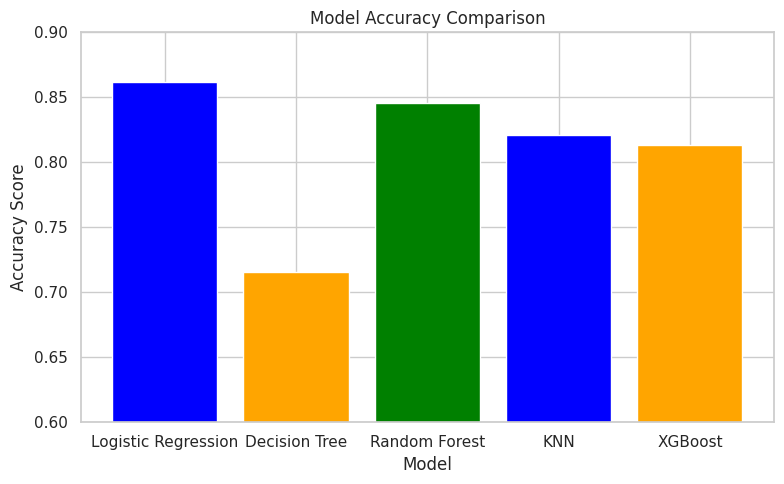

In [68]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'XGBoost']
accuracy_scores = [0.8618, 0.7154, 0.8455, 0.821, 0.813]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracy_scores, color=['blue', 'orange', 'green'])
plt.ylim(0.6, 0.9)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Risk Classification (High / Low Risk)

## Predict probabilities

In [69]:
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Define risk classification based on threshold
# Threshold can be adjusted as needed
threshold = 0.6
risk_level = ['High Risk' if prob < threshold else 'Low Risk' for prob in rf_prob]

## Add prediction and risk columns to the test set

In [70]:
output_df = X_test.copy()
output_df['Actual_Loan_Status'] = y_test.values
output_df['Predicted_Approval'] = rf_model.predict(X_test)
output_df['Approval_Probability'] = rf_prob
output_df['Risk_Level'] = risk_level

# Display top few rows of the result
print(output_df[['Approval_Probability', 'Predicted_Approval', 'Risk_Level']].head())

     Approval_Probability  Predicted_Approval Risk_Level
150                  0.03                   0  High Risk
559                  0.72                   1   Low Risk
598                  0.64                   1   Low Risk
235                  0.88                   1   Low Risk
145                  0.89                   1   Low Risk


# Applying Decision Logic

In [71]:
# Apply business logic to classify decisions
def apply_decision(risk):
    if risk == 'High Risk':
        return 'Manual Review'
    else:
        return 'Approve'

# Create Final Decision column
output_df['Final_Decision'] = output_df['Risk_Level'].apply(apply_decision)

# Display results
print(output_df[['Approval_Probability', 'Risk_Level', 'Final_Decision']].head())

     Approval_Probability Risk_Level Final_Decision
150                  0.03  High Risk  Manual Review
559                  0.72   Low Risk        Approve
598                  0.64   Low Risk        Approve
235                  0.88   Low Risk        Approve
145                  0.89   Low Risk        Approve


# Log and Store Results

In [72]:
# Reorganize the columns for final review
final_output = output_df.copy()
final_output = final_output.reset_index()  # Restore original indexes if needed

# Save to CSV
final_output.to_csv("Loan_Approval_Decision_Log.csv", index=False)

# Display top rows
print("Final Decision Log Preview:")
print(final_output[['index', 'Actual_Loan_Status', 'Predicted_Approval',
                    'Approval_Probability', 'Risk_Level', 'Final_Decision']].head())

Final Decision Log Preview:
   index  Actual_Loan_Status  Predicted_Approval  Approval_Probability  \
0    150                   0                   0                  0.03   
1    559                   1                   1                  0.72   
2    598                   1                   1                  0.64   
3    235                   1                   1                  0.88   
4    145                   1                   1                  0.89   

  Risk_Level Final_Decision  
0  High Risk  Manual Review  
1   Low Risk        Approve  
2   Low Risk        Approve  
3   Low Risk        Approve  
4   Low Risk        Approve  


# Saving Trained Model

In [73]:
# Save the trained Random Forest model
joblib.dump(rf_model, "final_rf_model.pkl")

# Optional: save the scaler too, if used during preprocessing
joblib.dump(scaler, "scaler.pkl")

# If you had a full pipeline, you could save that instead
# joblib.dump(full_pipeline, "model_pipeline.pkl")

print("Model and scaler saved successfully.")

Model and scaler saved successfully.
